## Imports

In [1]:
import os
import sys
import pysam
import pickle
import random
import modisco
import warnings
import plotnine
import pybedtools
import numpy as np
import tabix as tb
import pandas as pd
from plotnine import *
from pandas import Series
from kerasAC.splits import *
from viz_preprocess import *
from viz_sequence import *
from matplotlib import pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle

from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *

np.random.seed(1234)
plt.style.use('default')

TF-MoDISco is using the TensorFlow backend.
Using TensorFlow backend.


## Create Directories

In [2]:
#! /users/soumyak/alzheimers_parkinsons/gkmSVM/make_dirs.sh

## Generate Positive Sets

In [3]:
#! python /users/soumyak/alzheimers_parkinsons/gkmSVM/gen_positives.py

## Generate Negative Sets

In [4]:
#! python /users/soumyak/alzheimers_parkinsons/gkmSVM/run_seqdataloader.py

## Preprocess Inputs for training and testing

In [5]:
#! python /users/soumyak/alzheimers_parkinsons/gkmSVM/preprocess_gkm.py

## Train + Test + Evaluate gkmSVM

In [6]:
#! python /users/soumyak/alzheimers_parkinsons/gkmSVM/run_gkmsvm.py 24 all

## Get Peak Sets with GWAS intersections

In [7]:
#! python /users/soumyak/alzheimers_parkinsons/gkmSVM/get_gwas_inputs.py

## Interpret SVM using gkmExplain

In [8]:
#! python /users/soumyak/alzheimers_parkinsons/gkmSVM/run_gkmexplain.py 24 all

## Prepare Reference Alleles

In [9]:
cluster = '24'
fold = '1'
gwas_bed = pd.read_csv('/mnt/lab_data3/soumyak/adpd/version1_gkmSVM/Cluster'+cluster+'/fold'+fold+'/test/gwas.pos.bed', header=None, sep='\t')
gwas_chrom = gwas_bed[0].tolist()
gwas_start = gwas_bed[1].tolist()
gwas_end = gwas_bed[2].tolist()
gwas_rsid = gwas_bed[3].tolist()
gwas_ref = gwas_bed[4].tolist()
gwas_alt = gwas_bed[5].tolist()

ref_fasta = '/mnt/lab_data3/soumyak/adpd/version1_gkmSVM/Cluster'+cluster+'/fold'+fold+'/test/ref.pos.fasta'
ref_hyp_file = '/mnt/lab_data3/soumyak/adpd/version1_gkmSVM/Cluster'+cluster+'/fold'+fold+'/explain/output/ref_hyp_scores.txt'

ref_seqs = [x.rstrip() for (i,x) in enumerate(open(ref_fasta)) if i%2==1]
ref_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in ref_seqs if ('N' not in x)]

print("Num onehot sequences:", len(ref_onehot))

ref_hyp_scores = [w[0] for w in zip([
    np.array([[float(z) for z in y.split(",")]
                for y in x.rstrip().split("\t")[2].split(";")])
    for x in open(ref_hyp_file)], ref_seqs) if 'N' not in w[1]]

ref_imp_scores = get_impscores(ref_hyp_scores, ref_onehot)

assert (np.max([np.max(np.abs(z*y - x))
                for x,y,z in zip(ref_imp_scores,
                                 ref_onehot,
                                 ref_hyp_scores)])) == 0

ref_normed_imp_scores, ref_normed_hyp_scores = normalize_scores(
    impscores=ref_imp_scores, hyp_impscores=ref_hyp_scores, onehot_data=ref_onehot)

Num onehot sequences: 785


## Prepare Alternate Alleles

In [10]:
alt_fasta = '/mnt/lab_data3/soumyak/adpd/version1_gkmSVM/Cluster'+cluster+'/fold'+fold+'/test/alt.pos.fasta'
alt_hyp_file = '/mnt/lab_data3/soumyak/adpd/version1_gkmSVM/Cluster'+cluster+'/fold'+fold+'/explain/output/alt_hyp_scores.txt'
                                                                                
alt_seqs = [x.rstrip() for (i,x) in enumerate(open(alt_fasta)) if i%2==1]       
alt_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in alt_seqs if ('N' not in x)]
                                                                                
print("Num onehot sequences:", len(alt_onehot))                                 
                                                                                
alt_hyp_scores = [w[0] for w in zip([                                           
    np.array([[float(z) for z in y.split(",")]                                  
                for y in x.rstrip().split("\t")[2].split(";")])                 
    for x in open(alt_hyp_file)], alt_seqs) if 'N' not in w[1]]                 
                                                                                
alt_imp_scores = get_impscores(alt_hyp_scores, alt_onehot)                      
                                                                                
assert (np.max([np.max(np.abs(z*y - x))                                         
                for x,y,z in zip(alt_imp_scores,                                
                                 alt_onehot,                                    
                                 alt_hyp_scores)])) == 0                        
                                                                                
alt_normed_imp_scores, alt_normed_hyp_scores = normalize_scores(                
    impscores=alt_imp_scores, hyp_impscores=alt_hyp_scores, onehot_data=alt_onehot)

Num onehot sequences: 785


## Find Alternate Alleles that Break Accessibility

In [11]:
seq_dict = {'index':[], 'chr':[], 'start':[], 'end':[], 'ref_score':[], 'alt_score':[], 'delta':[]}

for i,j in enumerate(gwas_chrom):
    seq_dict['index'].append(i)
    seq_dict['chr'].append(gwas_chrom[i])
    seq_dict['start'].append(gwas_start[i])
    seq_dict['end'].append(gwas_end[i])
    seq_dict['ref_score'].append(np.sum(ref_imp_scores[i][400:600]))
    seq_dict['alt_score'].append(np.sum(alt_imp_scores[i][400:600]))
    seq_dict['delta'].append(np.sum(alt_imp_scores[i][400:600]) - np.sum(ref_imp_scores[i][400:600]))
    
seq_df = pd.DataFrame.from_dict(seq_dict)
seq_df.sort_values(by='delta', ascending=True, inplace=True)
seq_df.head()

,index,chr,start,end,ref_score,alt_score,delta
50,50,chr19,46291671,46291672,0.532519,-0.186559,-0.719077
555,555,chr2,127886157,127886158,1.855300,1.165403,-0.689896
337,337,chr19,45440760,45440761,-0.255249,-0.869133,-0.613883
311,311,chr19,45342123,45342124,-0.823222,-1.385937,-0.562715
156,156,chr19,1039185,1039186,0.177941,-0.381581,-0.559521


## Get 10 bp around SNP

In [12]:
ref_seq = pysam.FastaFile('/mnt/data/pipeline_genome_data/hg19/male.hg19.fa')
for idx in seq_df.iloc[:5]['index']:
    print(ref_seq.fetch(gwas_chrom[idx], gwas_end[idx] - 10, gwas_end[idx] + 10))

tagtcacttctgccttccag
cagaagccccgcccaatgag
CAggccaggagcagtggctt
gtggctcacgcctgtaatcc
CCATTGGGAGGAGGAGCAAA


## Visualize Top Sequences

Index:  50  Importance:  0.5325186254000001  RSID:  rs55681266   chr19 : 46291671 - 46291672
Reference Allele:  C


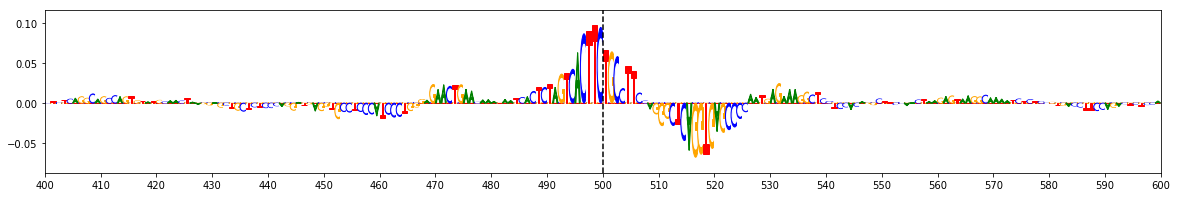

Index:  50  Importance:  -0.186558629  RSID:  rs55681266
Alternate Allele:  A


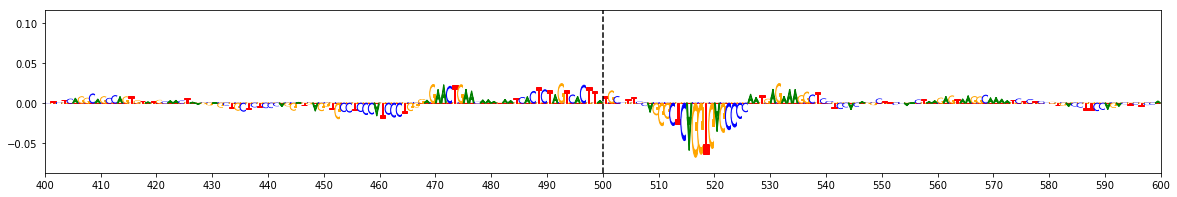

Index:  50  Delta:  -0.7190772544  RSID:  rs55681266
Alt - Ref:  A - C


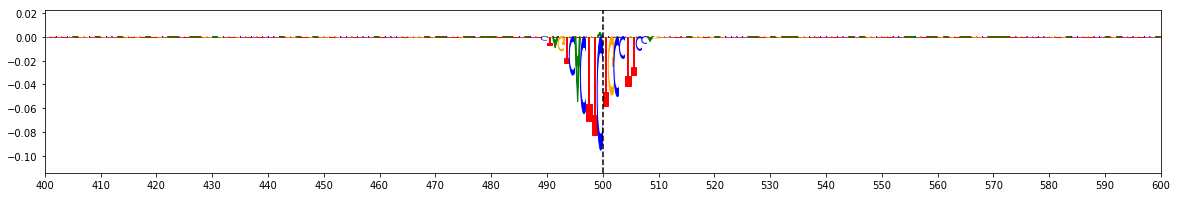

Index:  555  Importance:  1.8552998396999998  RSID:  rs13025717   chr2 : 127886157 - 127886158
Reference Allele:  C


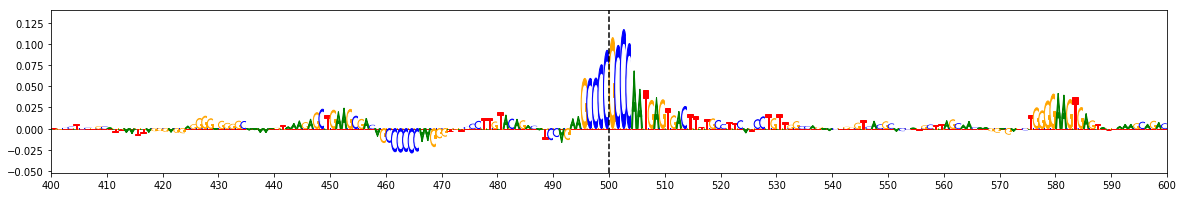

Index:  555  Importance:  1.16540341285  RSID:  rs13025717
Alternate Allele:  T


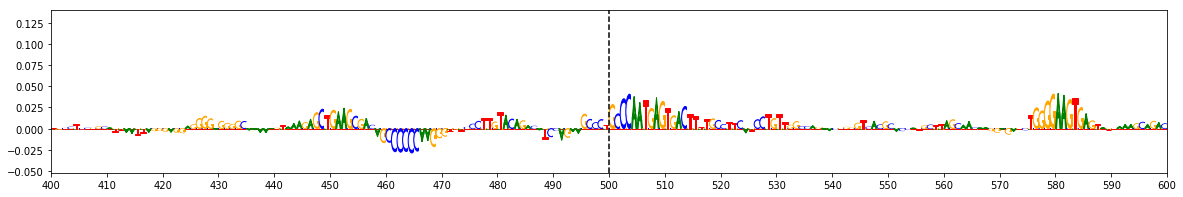

Index:  555  Delta:  -0.6898964268499999  RSID:  rs13025717
Alt - Ref:  T - C


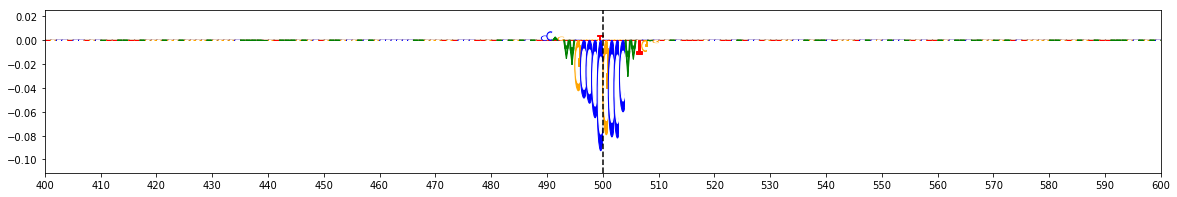

Index:  337  Importance:  -0.25524906412  RSID:  rs34810028   chr19 : 45440760 - 45440761
Reference Allele:  A


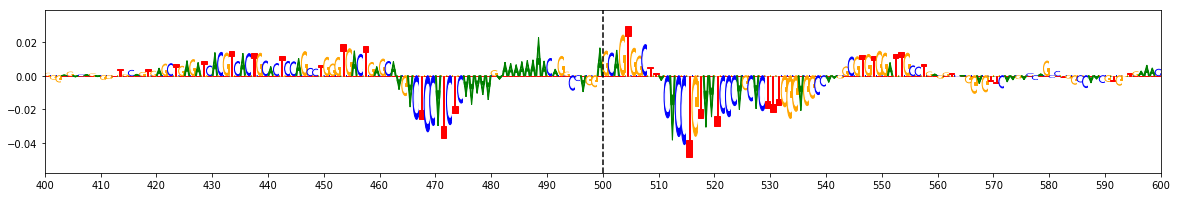

Index:  337  Importance:  -0.8691325327900001  RSID:  rs34810028
Alternate Allele:  T


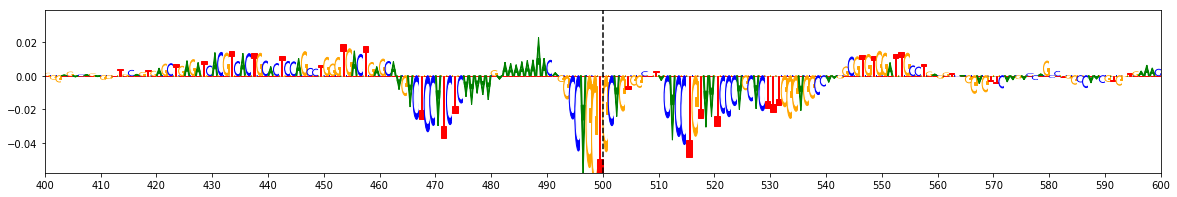

Index:  337  Delta:  -0.6138834686700001  RSID:  rs34810028
Alt - Ref:  T - A


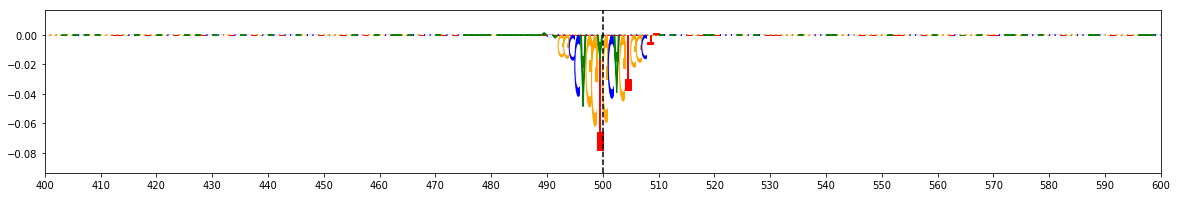

Index:  311  Importance:  -0.8232221408999999  RSID:  rs10408472   chr19 : 45342123 - 45342124
Reference Allele:  G


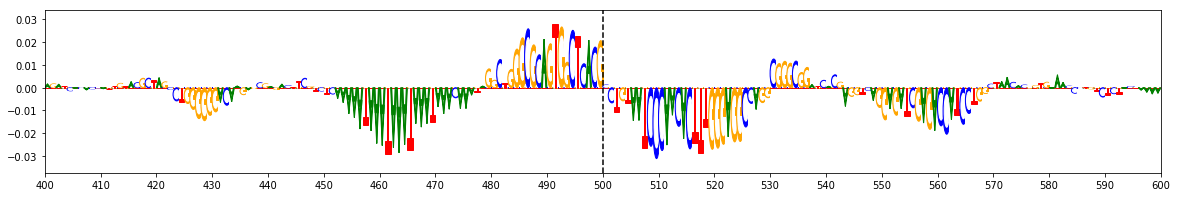

Index:  311  Importance:  -1.3859368193  RSID:  rs10408472
Alternate Allele:  A


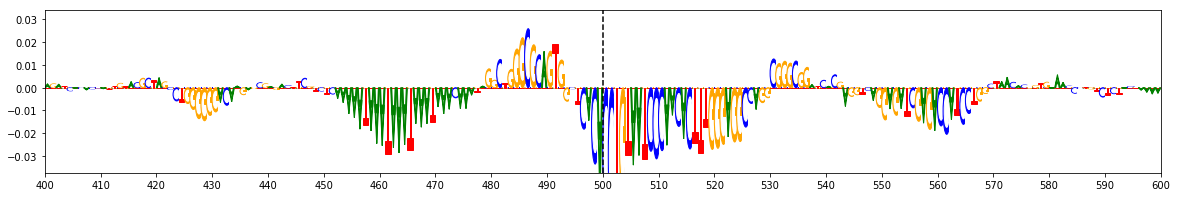

Index:  311  Delta:  -0.5627146784  RSID:  rs10408472
Alt - Ref:  A - G


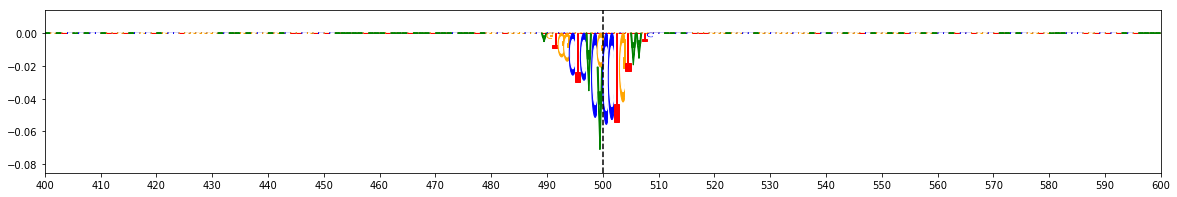

Index:  156  Importance:  0.17794056460000002  RSID:  rs4807468   chr19 : 1039185 - 1039186
Reference Allele:  G


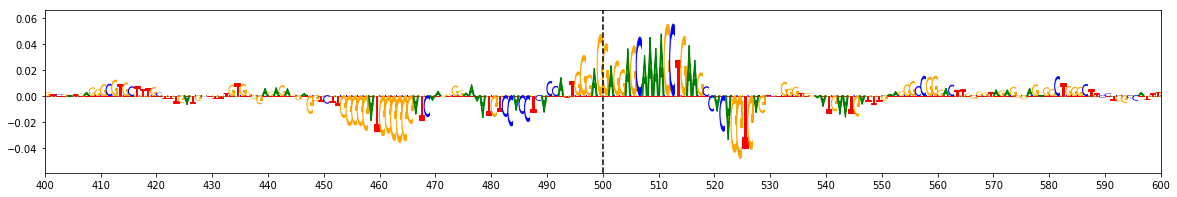

Index:  156  Importance:  -0.3815807011  RSID:  rs4807468
Alternate Allele:  A


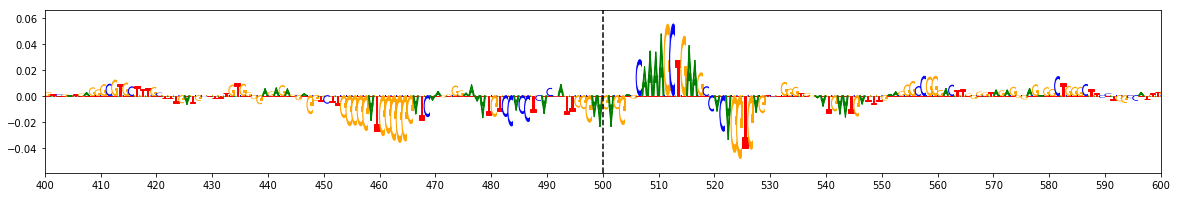

Index:  156  Delta:  -0.5595212656999999  RSID:  rs4807468
Alt - Ref:  A - G


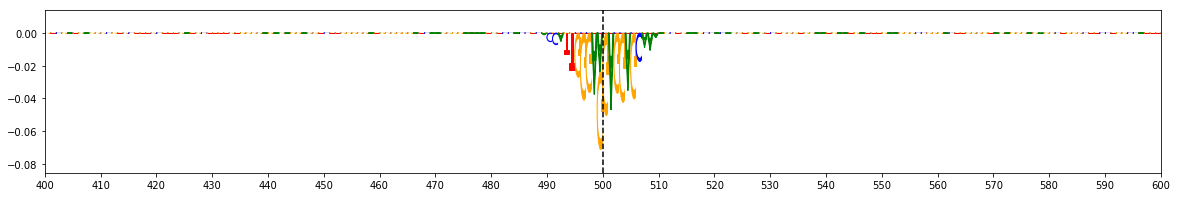

In [13]:
for idx in seq_df.iloc[:5]['index']:
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'ref_score'], " RSID: ", gwas_rsid[idx], 
          ' ', seq_df.at[idx, 'chr'], ':', seq_df.at[idx, 'start'], '-', seq_df.at[idx, 'end'])
    print("Reference Allele: ", gwas_ref[idx])
    ylim = plot_weights(ref_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'alt_score'], " RSID: ", gwas_rsid[idx])
    print("Alternate Allele: ", gwas_alt[idx])
    a = plot_weights(alt_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df.at[idx, 'delta'], " RSID: ", gwas_rsid[idx])
    print("Alt - Ref: ", gwas_alt[idx] + ' - ' + gwas_ref[idx])
    a = plot_weights(alt_imp_scores[idx] - ref_imp_scores[idx], subticks_frequency=10, xlim=(400,600))

## Find Alternate Alleles that Improve Accessibility

In [14]:
seq_df.sort_values(by='delta', ascending=False, inplace=True)
seq_df.head()

,index,chr,start,end,ref_score,alt_score,delta
774,774,chr19,45388129,45388130,0.440043,1.365292,0.925250
551,551,chr19,45301923,45301924,1.065520,1.927352,0.861832
499,499,chr19,45455705,45455706,0.156215,0.998782,0.842567
646,646,chr19,45353260,45353261,0.254892,0.890893,0.636001
203,203,chr2,127865103,127865104,0.219543,0.836127,0.616585


## Visualize Top Sequences

Index:  774  Importance:  0.4400426838  RSID:  rs34342646 chr19 :  45388129  -  45388130
Alternate Allele:  A


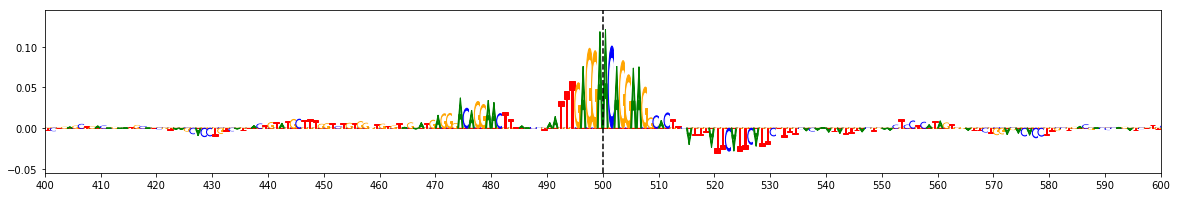

Index:  774  Importance:  0.4400426838  RSID:  rs34342646
Reference Allele:  G


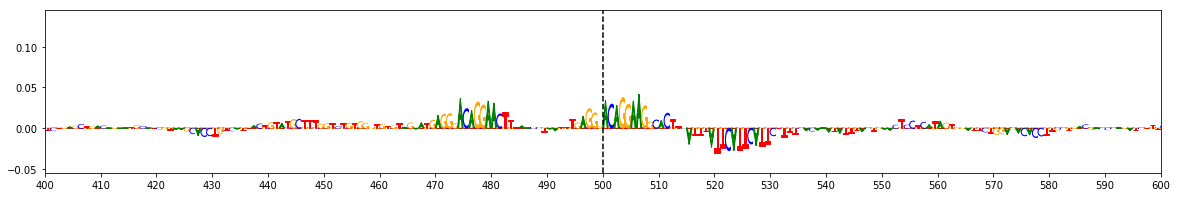

Index:  774  Delta:  0.9252495689000004  RSID:  rs34342646
Alt - Ref:  A - G


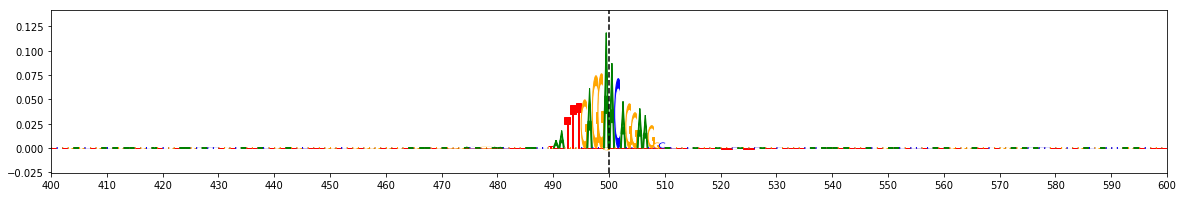

Index:  551  Importance:  1.0655204844  RSID:  rs2965113 chr19 :  45301923  -  45301924
Alternate Allele:  A


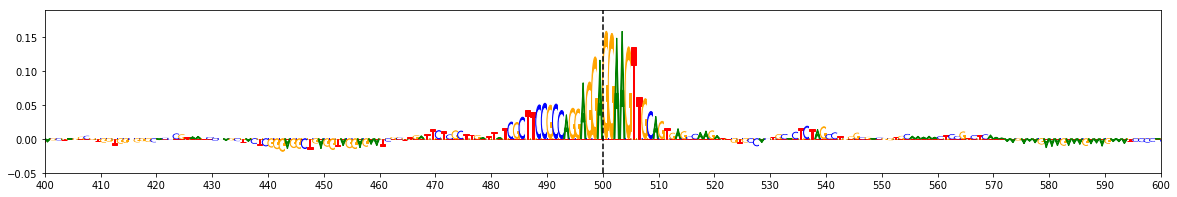

Index:  551  Importance:  1.0655204844  RSID:  rs2965113
Reference Allele:  T


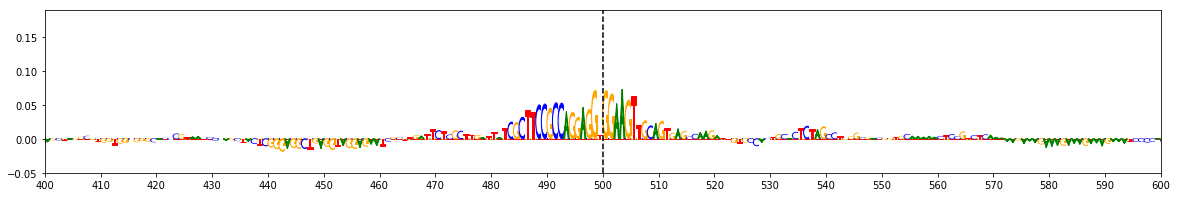

Index:  551  Delta:  0.8618317529000001  RSID:  rs2965113
Alt - Ref:  A - T


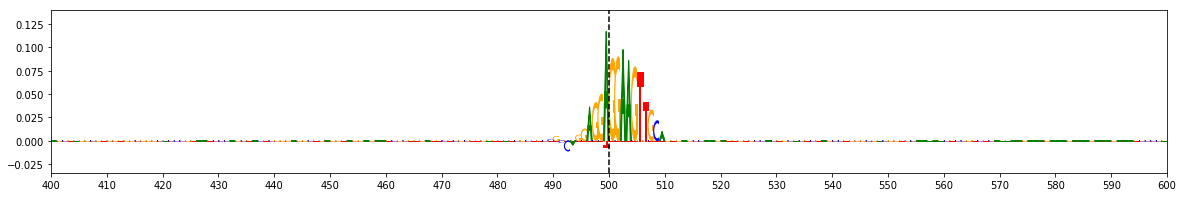

Index:  499  Importance:  0.15621518309999996  RSID:  rs7251501 chr19 :  45455705  -  45455706
Alternate Allele:  T


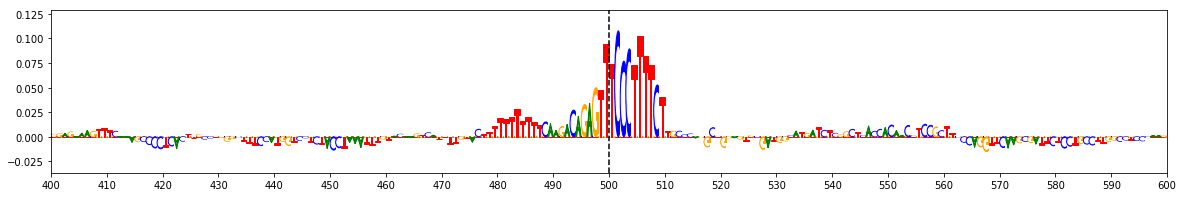

Index:  499  Importance:  0.15621518309999996  RSID:  rs7251501
Reference Allele:  C


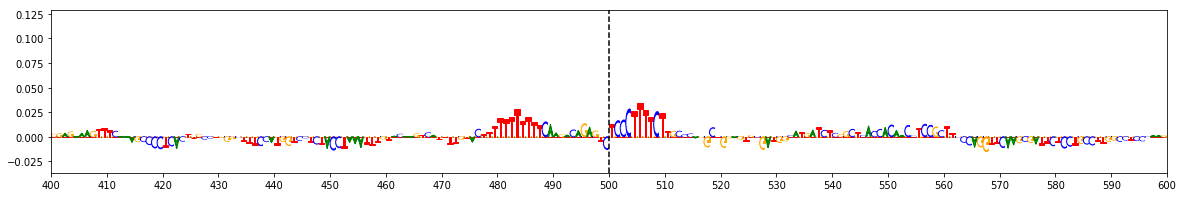

Index:  499  Delta:  0.8425670770999999  RSID:  rs7251501
Alt - Ref:  T - C


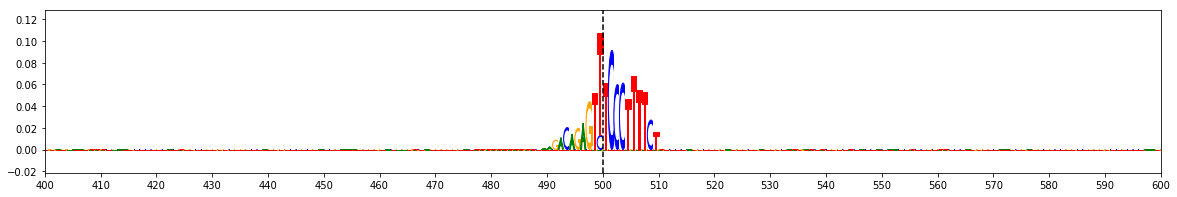

Index:  646  Importance:  0.2548918513000001  RSID:  rs1531516 chr19 :  45353260  -  45353261
Alternate Allele:  A


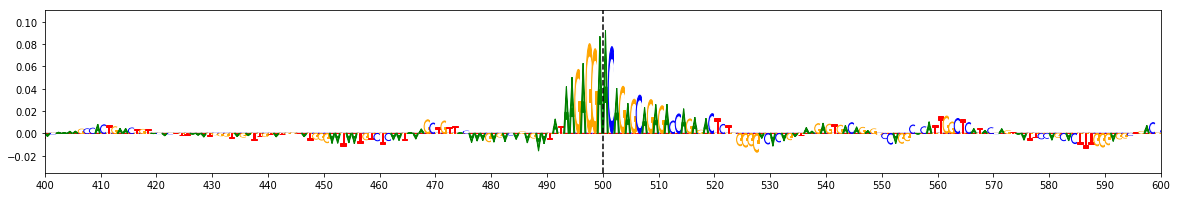

Index:  646  Importance:  0.2548918513000001  RSID:  rs1531516
Reference Allele:  C


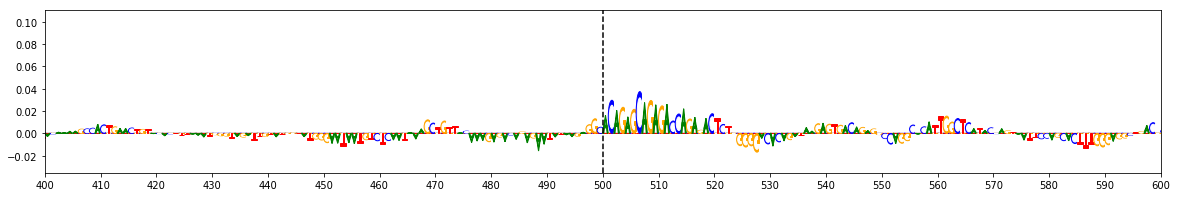

Index:  646  Delta:  0.636001456  RSID:  rs1531516
Alt - Ref:  A - C


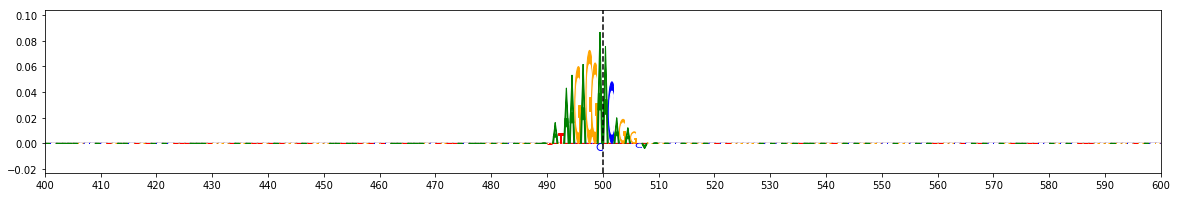

Index:  203  Importance:  0.21954257099999996  RSID:  rs77260225 chr2 :  127865103  -  127865104
Alternate Allele:  G


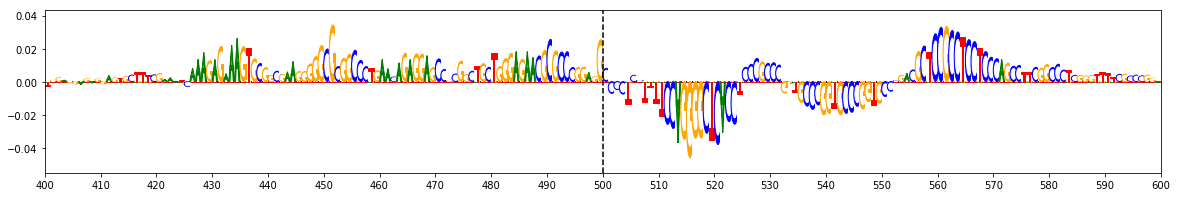

Index:  203  Importance:  0.21954257099999996  RSID:  rs77260225
Reference Allele:  C


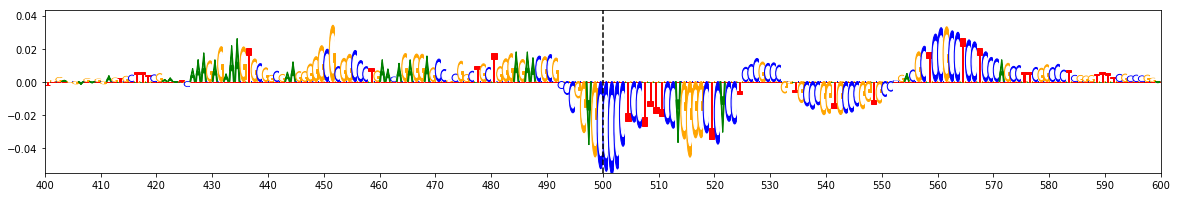

Index:  203  Delta:  0.616584683  RSID:  rs77260225
Alt - Ref:  G - C


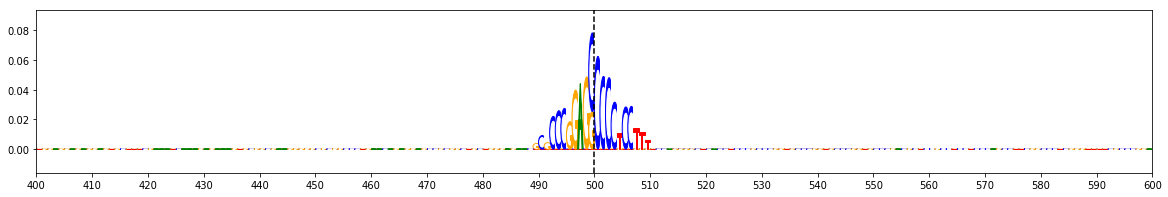

In [15]:
for idx in seq_df.iloc[:5]['index']:
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'ref_score'], " RSID: ", gwas_rsid[idx], 
          seq_df.at[idx, 'chr'], ': ', seq_df.at[idx, 'start'], ' - ', seq_df.at[idx, 'end'])
    print("Alternate Allele: ", gwas_alt[idx])
    ylim = plot_weights(alt_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'ref_score'], " RSID: ", gwas_rsid[idx])
    print("Reference Allele: ", gwas_ref[idx])
    a = plot_weights(ref_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df.at[idx, 'delta'], " RSID: ", gwas_rsid[idx])
    print("Alt - Ref: ", gwas_alt[idx] + ' - ' + gwas_ref[idx])
    a = plot_weights(alt_imp_scores[idx] - ref_imp_scores[idx], subticks_frequency=10, xlim=(400,600))